In [106]:
import numpy as np
import bioframe
import cooler
import cooltools
import powerlaw as pl
import matplotlib.pyplot as plt

import pandas as pd

# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [107]:
samples = [0, 12, 30, 60]
resolution = 10_000
diag_skip = 2
NPROC = 24
clrs_ = [cooler.Cooler(f'/cta/users/vkaya/gnn/matrix/matrix/t{sample}_q30.mcool::/resolutions/{resolution}') for sample in samples]

In [108]:
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clrs_[0].chromnames)].reset_index(drop=True)

In [109]:
expected_ = [pd.read_csv(f'/cta/users/vkaya/hi-c/work/hela/notebooks/expected/expected_{resolution}_{sample}.hg38_arms.csv') for sample in samples]

In [110]:
# expected_ = [cooltools.expected_cis(
#         clr=clr,
#         view_df=hg38_arms,
#         smooth=True,
#         aggregate_smoothed=True,
#         nproc=NPROC,
#         clr_weight_name='weight',
#         ignore_diags = diag_skip) for clr in clrs_]

# for i, expected in enumerate(expected_):
#     expected.to_csv(f'/cta/users/vkaya/hi-c/work/hela/notebooks/expected/expected_{resolution}_{samples[i]}.hg38_arms.csv', index=False)

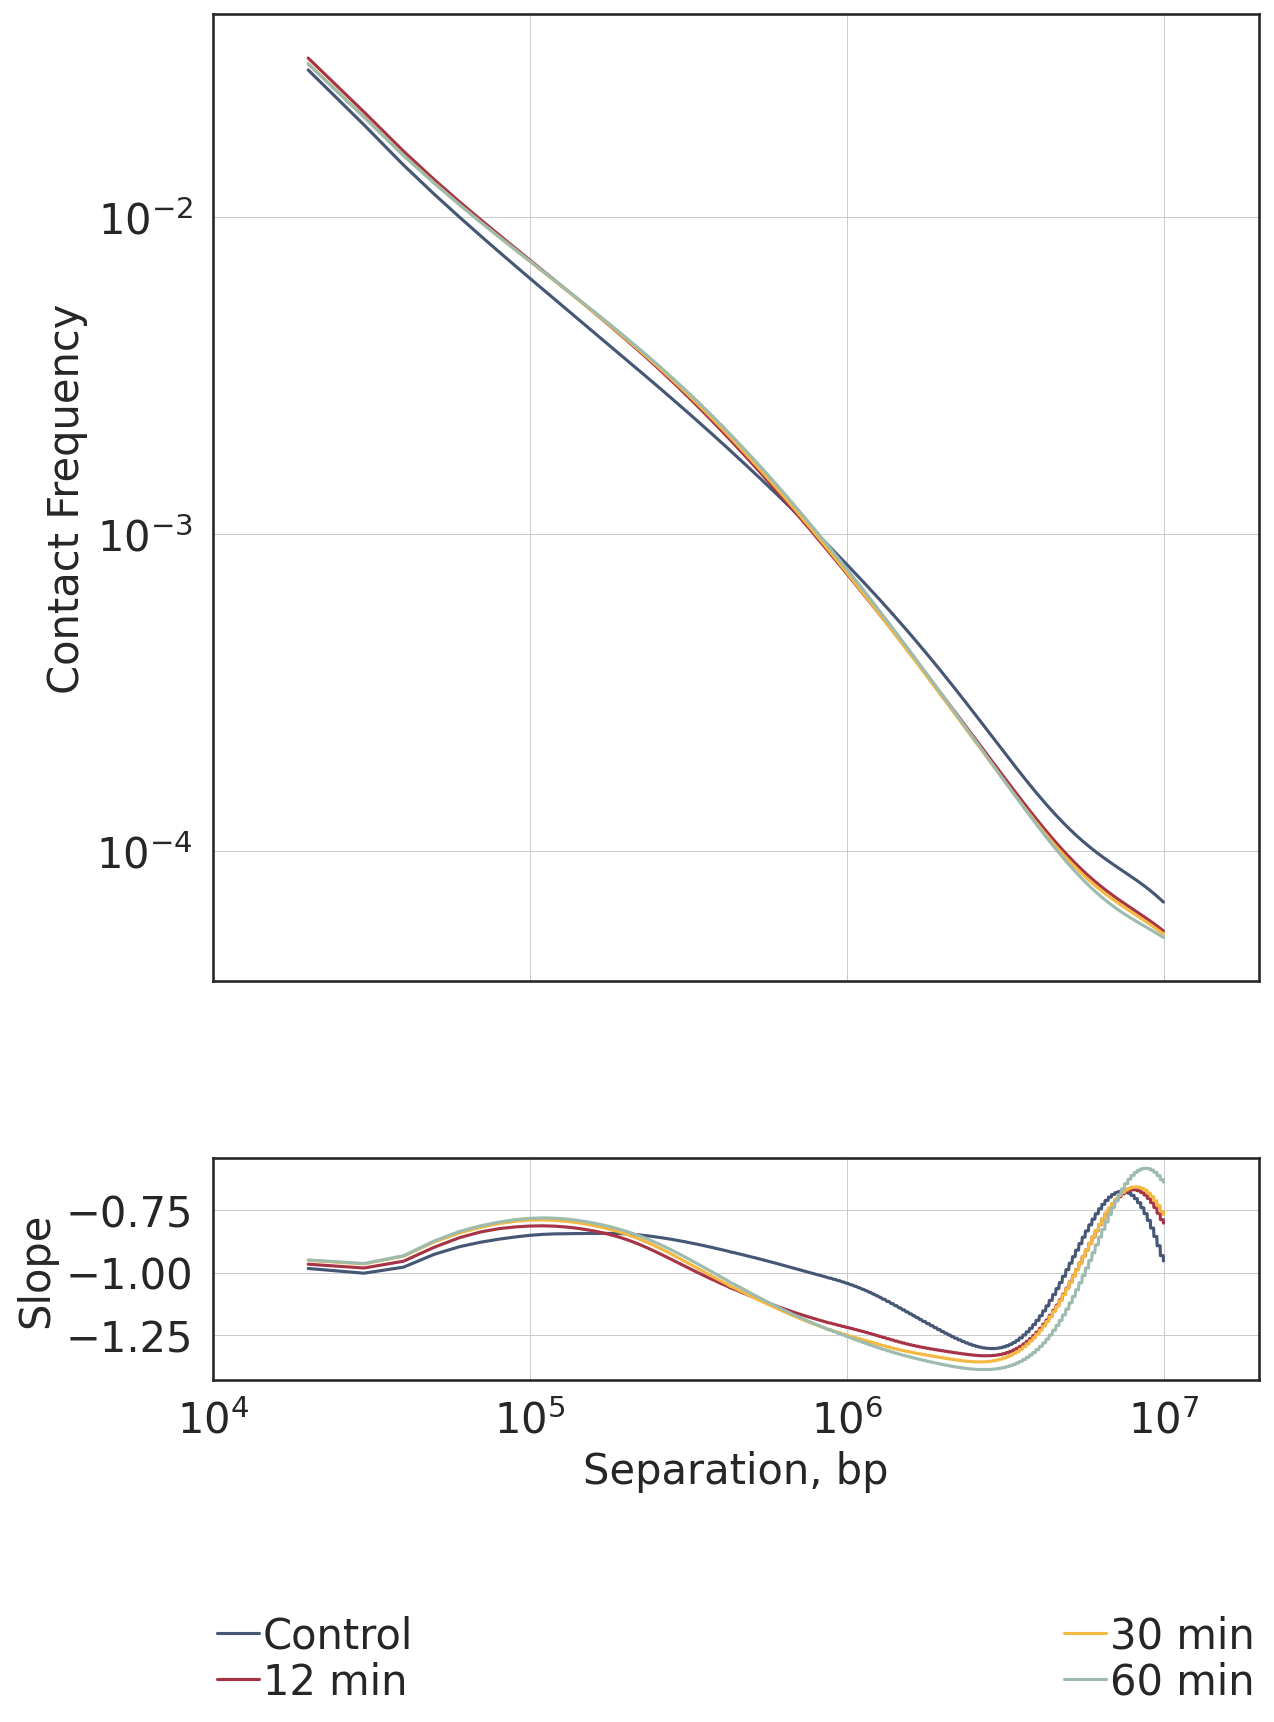

In [112]:
f, axs = plt.subplots(
    figsize=(9,13),
    nrows=2,
    gridspec_kw={'height_ratios':[16,3], 'hspace':0.1},
    sharex=True)

data = []
der_data = []
dist = []
samples = [0, 12, 30, 60]
s_colors = ['#465775', '#A63446', '#F5B841', '#9DBBAE']


sns.set_style("white")

# upper limit in bp ~ 10MB
upper_limit = 1e7

for expected, sample, s_color in zip(expected_, samples, s_colors):
    
    expected['s_bp'] = expected['dist']* resolution
    
    expected.loc[expected.dist < diag_skip , 'balanced.avg.smoothed.agg'] = np.nan
    
    cvd_merged = expected.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']][diag_skip:]
    
    data.append(np.array(cvd_merged['balanced.avg.smoothed.agg']))
    der = np.gradient(np.log(cvd_merged['balanced.avg.smoothed.agg']),
                  np.log(cvd_merged['s_bp']))
    der_data.append(der)
    dist.append(np.array(cvd_merged['s_bp']))

    cvd_merged = cvd_merged[cvd_merged['s_bp'] < upper_limit]
    der = der[:len(cvd_merged)]

    ax = axs[0]
    ax.loglog(
        cvd_merged['s_bp'],
        cvd_merged['balanced.avg.smoothed.agg'],
        '-',
        markersize=8,
        color = s_color,
    )
    
    ax.set(
        ylabel='Contact Frequency',
        xlim=(1e4,2*1e7),
        # ylim=(1e-6,5*1e-2),
    )
    ax.set_aspect(1.0)
    ax.grid(lw=0.5)

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)

    ax = axs[1]
    ax.semilogx(
        cvd_merged['s_bp'],
        der,
        #alpha=0.5,
        color = s_color,
    )

    ax.set(
        xlabel='Separation, bp',
        ylabel='Slope',
        )

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)

    ax.grid(lw=0.5)

# add custom legend for sample colors
axs[0].legend(
    ['Control'] + [f'{sample} min' for sample in samples[1:]],
    loc='lower left',
    bbox_to_anchor=(0.0, -0.75, 1.0, 1.0),
    ncol=2,
    mode='expand',
    borderaxespad=0.0,
    fontsize=20,
    frameon=False,
    columnspacing=0.5,
    handletextpad=0.1,
    handlelength=1.0,
    markerscale=2.0,
    labelspacing=0.1,
    borderpad=0.1,
    )

for ax in axs.flatten():
    ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig("dist_decay.svg", bbox_inches='tight')

In [113]:
plt.rcParams['figure.dpi'] = 150


In [114]:
from itertools import combinations
import seaborn as sns
import pandas as pd
samples = ['Control', '12 min', '30 min', '60 min']
combs = list(combinations(list(range(len(samples))) * 2, 2))
combs = [comb for comb in combs if comb[0] != comb[1]]
df_list = []
for i, comb in enumerate(combs):
    data1 = data[comb[0]]
    data2 = data[comb[1]]
    l2fc = data2/data1
    df_data = {
        'l2fc': l2fc,
        'dist': dist[comb[0]],
        'sample1': samples[comb[0]],
        'sample2': samples[comb[1]],
    }
    df = pd.DataFrame(df_data)
    df_list.append(df)

all_DF = pd.concat(df_list)

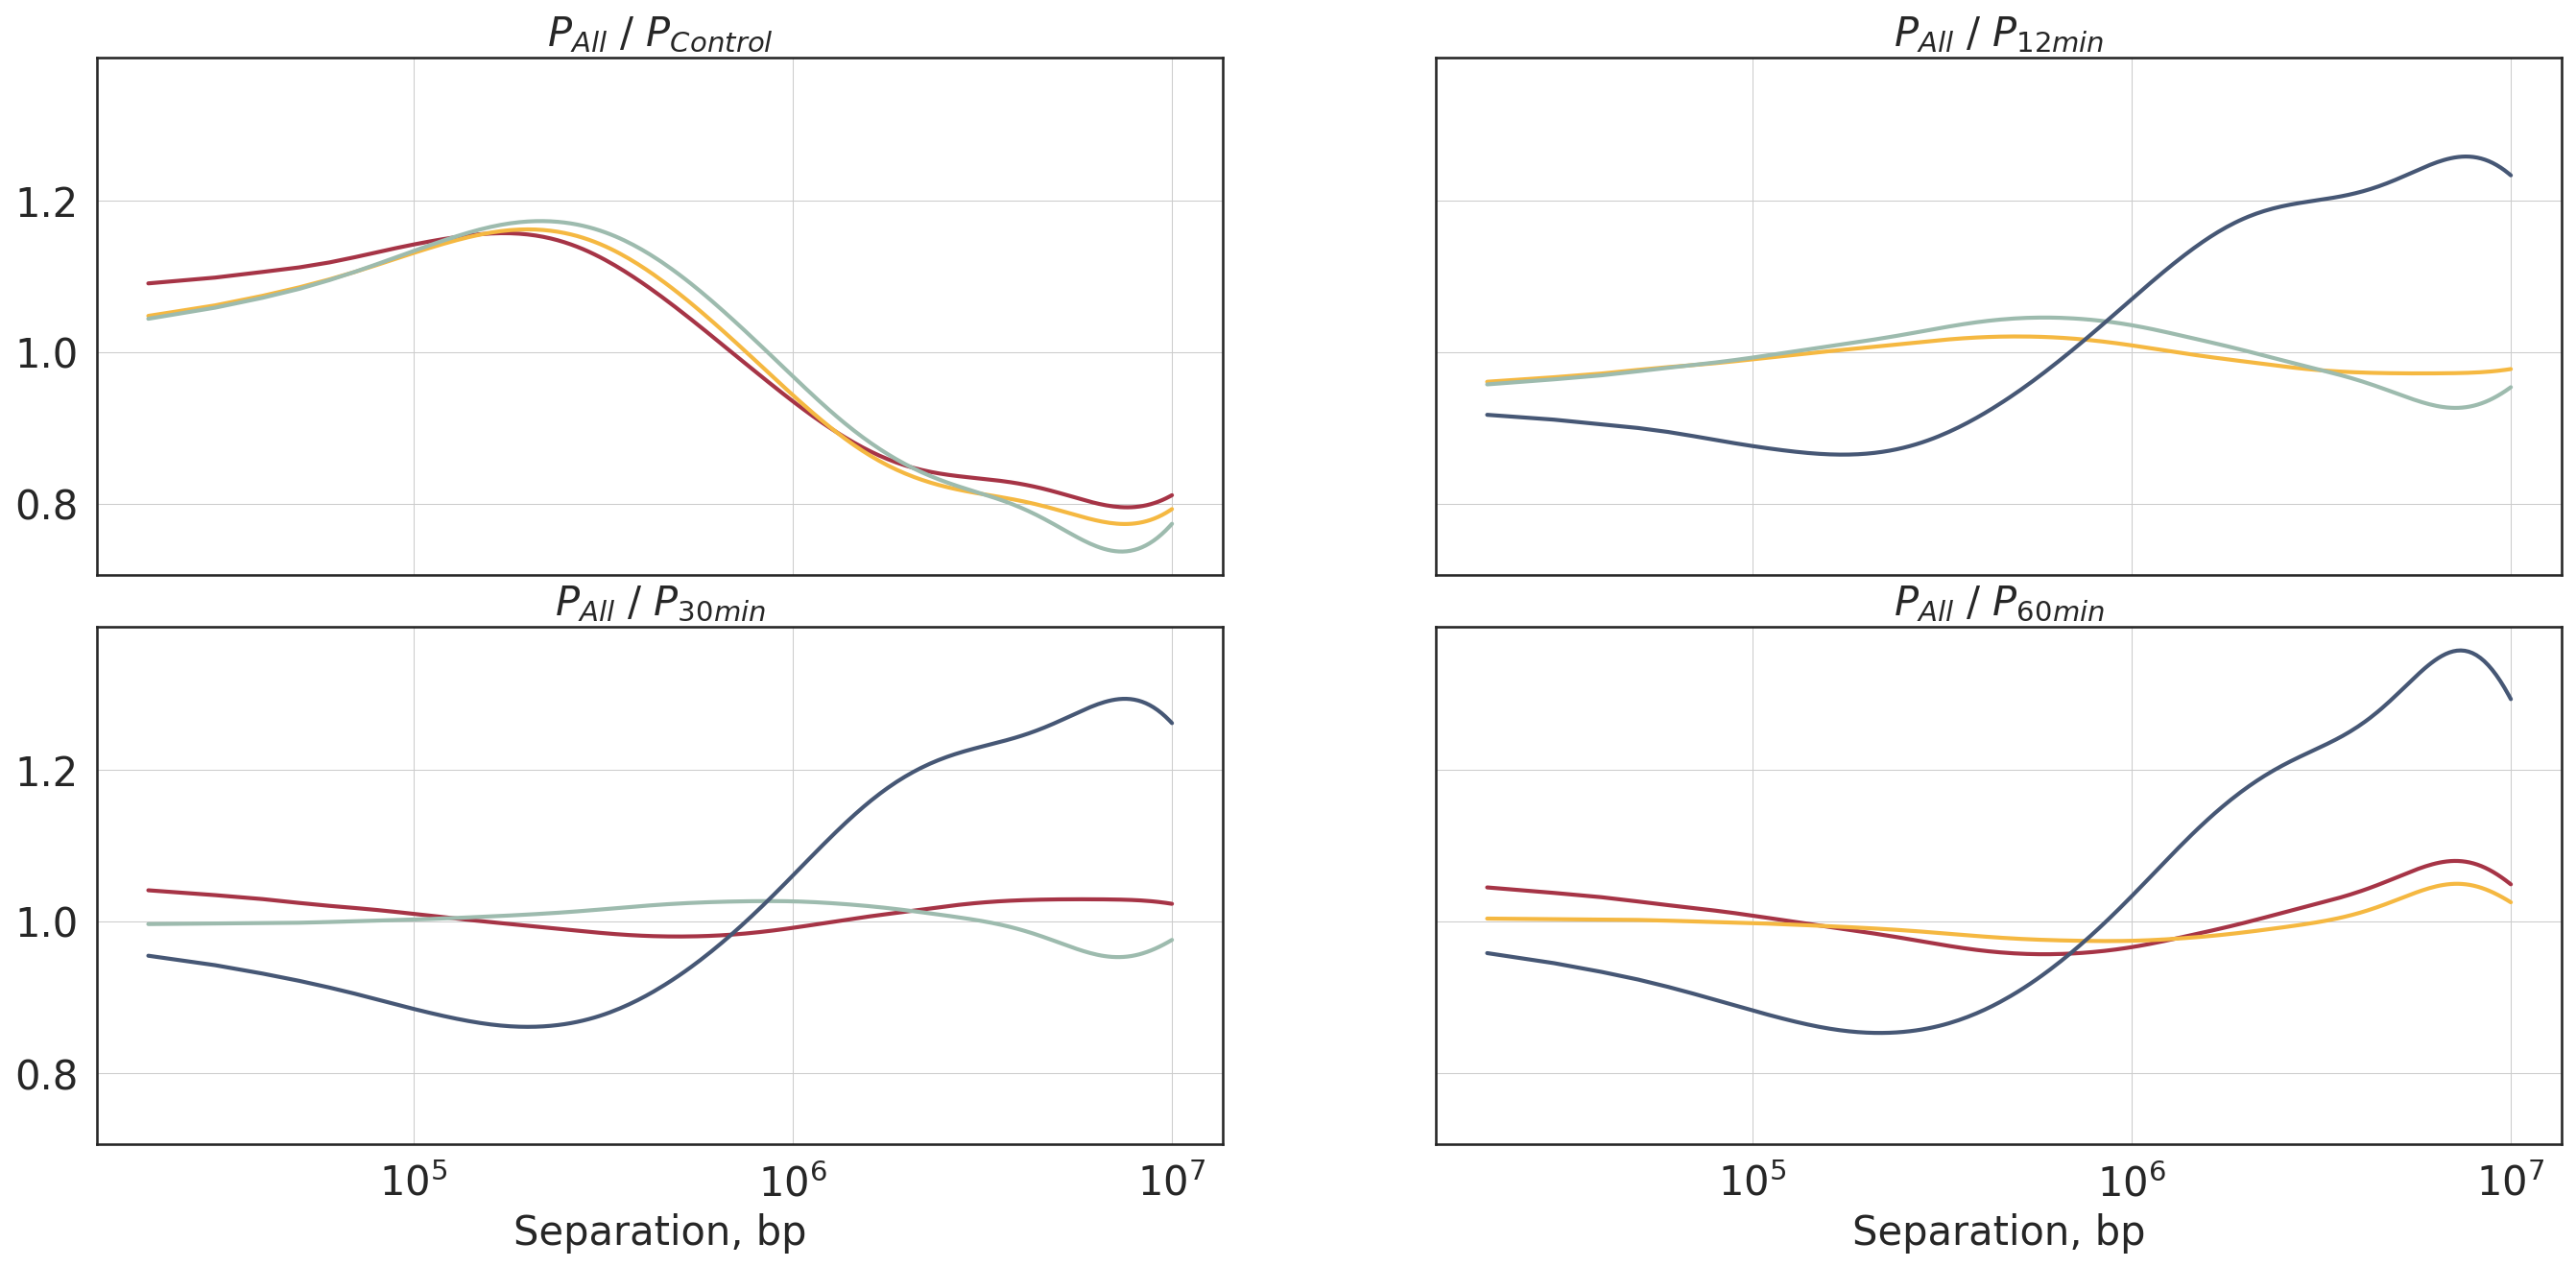

In [115]:

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24,10), sharex=True, sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0})
mapping = {0: (0,0), 1: (0,1), 2: (1,0), 3: (1,1)}
color_mapping = {'Control': '#465775', '12 min': '#A63446', '30 min': '#F5B841', '60 min': '#9DBBAE'}
sample_order = ['Control', '12 min', '30 min', '60 min']

for ax_i in axs.flatten():
    ax_i.tick_params(axis='both', which='major', labelsize=20)

for i, sample in enumerate(samples):
    data_curr = all_DF[all_DF['sample1'] == sample]
    data_curr = data_curr[data_curr['dist'] <= 1e7]
    
    data_curr.sort_values(by=['sample2'], inplace=True)

    current_color_mapp = {
        s: color_mapping[s] for s in data_curr['sample2'].unique().tolist()
    }

    ax_i = ax[mapping[i]]
    # do not plot legend for all subplots
    s = sns.lineplot(data=data_curr, x='dist', y='l2fc', hue='sample2', errorbar=None, palette=current_color_mapp, legend=False, linewidth=2, ax=ax_i)
    #s.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., title='Sample 2')
    s.set_xlabel('Separation, bp', fontsize=20)
    ss = "$P_{" + sample + "}$"
    ss2 = "$P_{All}$"
    s.set_ylabel("")
    s.set(xscale="log")
    ss3 = "$log_{2}$"
    s.set_title(f'{ss2} / {ss}', fontsize=20)
    s.grid(lw=0.5)
    s.set_aspect(2)

    #ax_i.yaxis.set_tick_params(labelbottom=True)

for ax_i in ax.flatten():
    ax_i.tick_params(axis='both', which='major', labelsize=20)

plt.savefig("dist_decay_diff.svg", bbox_inches='tight')

In [116]:
max_dist = 10_000_000
sample_names = ['Control', '12-mins', '30-mins', '60-mins']
df_dict = {'sample': sample_names, 'alpha': []}
for i in range(4):
    end = max_dist // resolution - diag_skip
    x = data[i][:end]
    fit = pl.Fit(x)
    a, s, x_Min = fit.alpha, fit.sigma, fit.xmin
    df_dict['alpha'].append(a)
alpha_DF = pd.DataFrame(df_dict)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [117]:
alpha_DF

,sample,alpha
0,Control,1.917115
1,12-mins,1.847220
2,30-mins,1.834519
3,60-mins,1.821247
